In [2]:
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join

In [3]:
ALGORITHMS = {
    'hist': 'Historgram',
    'lblint_ix': 'Structure Filter',
    'bib': 'Binary brach',
    'tang': 'Tang',
    'sed': 'String Edit LB',
    'sed_k': 'Bounded SED LB',
    'lblint': 'Label Intersection'
}

In [4]:
BASEPATH = 'results'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for ALG in ALGORITHMS.keys():
        path = f'{BASEPATH}/{dataset.lower()}/{ALG}_us.txt'
        if not exists(path):
            print(ALG, 'is not computed for', dataset, f'{path} skipping')
            continue
        
        path2 = f'{BASEPATH}/{dataset.lower()}/precision-{ALG}-{threshold}.txt'
        df = pd.read_csv(path, names=["time"])
        precision = pd.read_csv(path2, delimiter=';')
        algorithm_times[ALG] = [df, precision]
    return algorithm_times

In [5]:
tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]

In [5]:
dataframes = dict()
for ds, t in tested_values:
    dataframes[ds] = load_dataset(ds, t)

,Dataset,Min tree size,Max tree size,Average tree size,No. of distinct labels,No. of trees in dataset,Max node degree,Min node degree,Mean node degree,Mean tree height (root to leaf distance),Max tree height,Min tree height
0,Swissprot,94,5548,431,152539,5000,562,1,1.995,3.125,6,2
0,Bolzano,2,2195,179,593,299,198,1,1.989,2.841,3,1
0,Python,1,26544,1007,27170,500,186,0,1.998,8.766,62,0
0,Sentiment,3,103,37,19470,9645,3,1,1.946,7.015,29,1
0,Ptb,3,711,72,13108,3914,33,1,1.972,6.858,29,2
0,Treefam,63,14791,2638,430109,1500,8,1,1.999,16.696,60,2
0,Dblp,11,1703,26,375713,50000,430,1,1.923,2.018,5,2


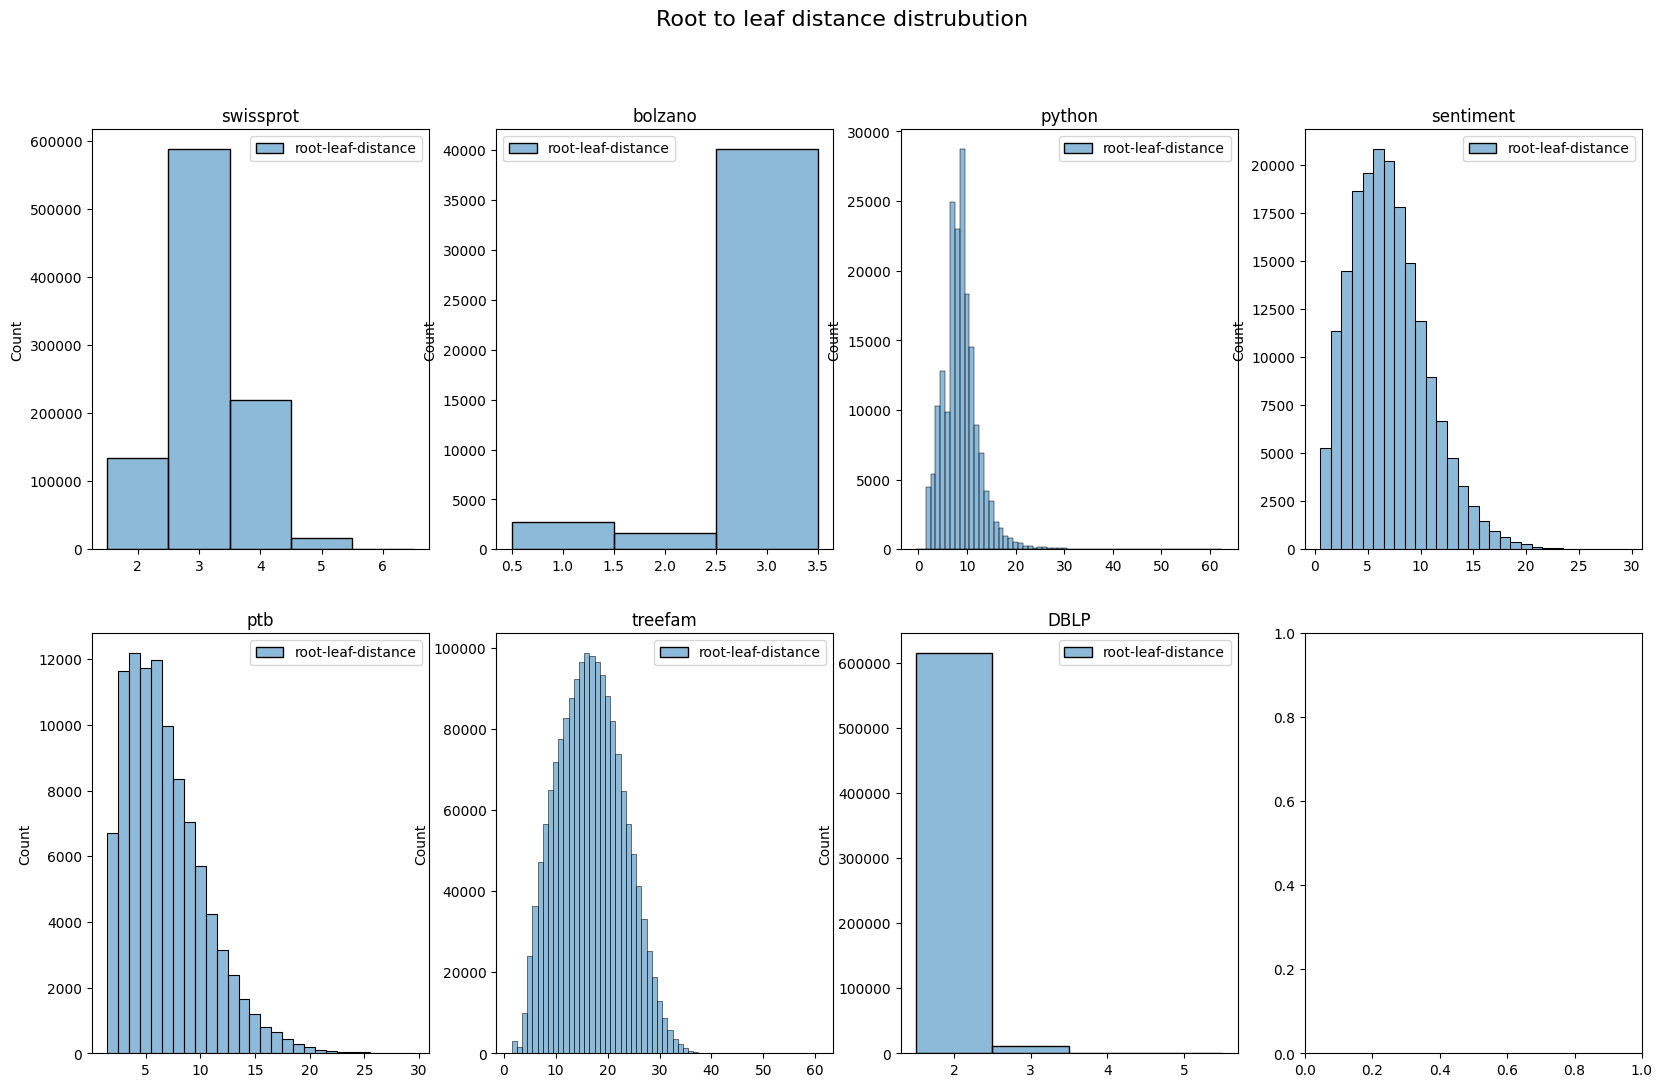

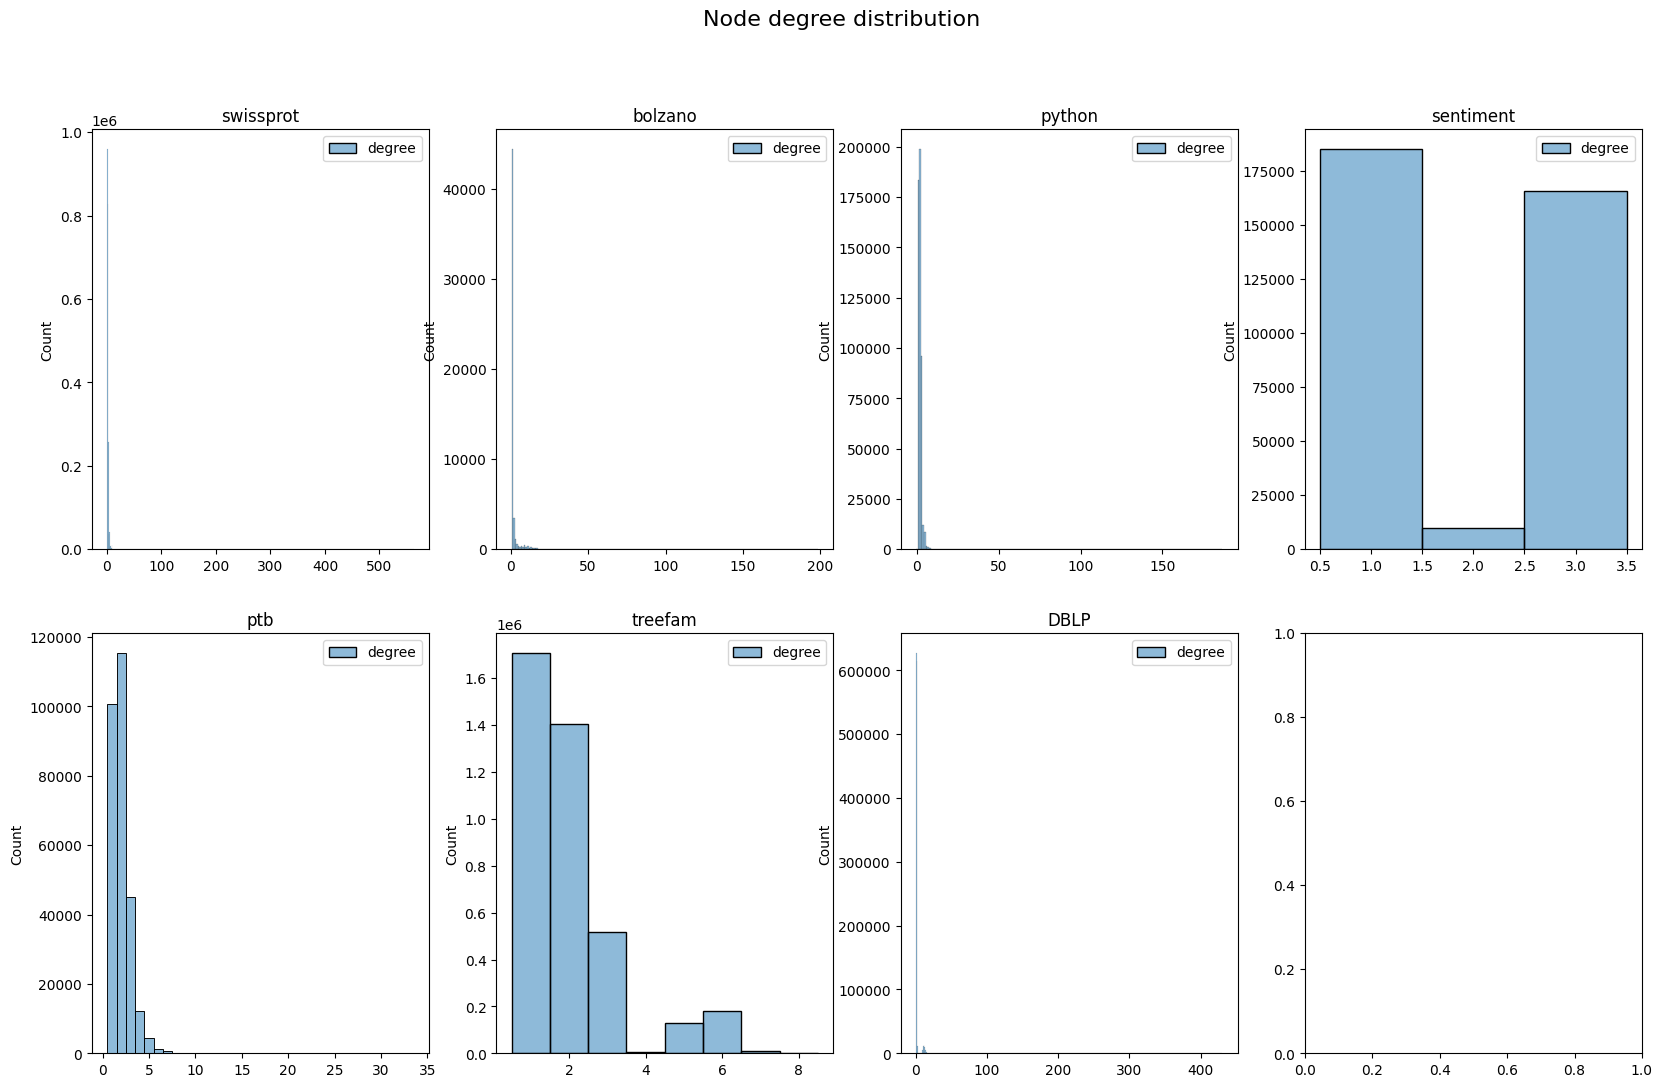

In [6]:
def load_stats(dataset: str):
    ds_path = join(BASEPATH, dataset.lower())
    path = join(ds_path, 'stats.csv')
    df = pd.read_csv(path)
    depths = pd.read_csv(join(ds_path, 'depths.csv'), names=['root-leaf-distance'], header=None)
    degrees = pd.read_csv(join(ds_path, 'degrees.csv'), names=['degree'], header=None)

    df.insert(0, 'Dataset', [dataset.capitalize()], True)
    df.insert(6, 'Mean node degree', [degrees['degree'].mean()])
    df.insert(6, 'Min node degree', [degrees['degree'].min()])
    df.insert(6, 'Max node degree', [degrees['degree'].max()])
    df.insert(9, 'Min tree height', [depths['root-leaf-distance'].min()])
    df.insert(9, 'Max tree height', [depths['root-leaf-distance'].max()])
    df.insert(9, 'Mean tree height (root to leaf distance)', [depths['root-leaf-distance'].mean()])
    return (df, depths, degrees)

f, axes = plt.subplots(2, 4, figsize=(20, 12))
f2, axes2 = plt.subplots(2, 4, figsize=(20, 12))
f.suptitle('Root to leaf distance distrubution', fontsize=16)
f2.suptitle('Node degree distribution', fontsize=16)
df = pd.DataFrame()
for i, (ds, _) in enumerate(tested_values):
    row = int(i >= 4)
    col = i % 4
    loaded, dep, deg = load_stats(ds)
    hp = sns.histplot(data=dep, ax=axes[row][col], discrete=True)
    hp.set(title=ds)
    hp2 = sns.histplot(data=deg, ax=axes2[row][col], discrete=True)
    hp2.set(title=ds)
    df = pd.concat([df, loaded])

pd.set_option('display.precision', 3)

df.reset_index()
df = df.rename(columns={
    'mint': 'Min tree size',
    'maxt': 'Max tree size',
    'avgt': 'Average tree size',
    'distinct_labels': 'No. of distinct labels',
    'trees': 'No. of trees in dataset',
})
display(df)

Printing  swissprot
Printing  bolzano
Printing  python
Printing  sentiment
Printing  ptb
Printing  treefam
Printing  DBLP


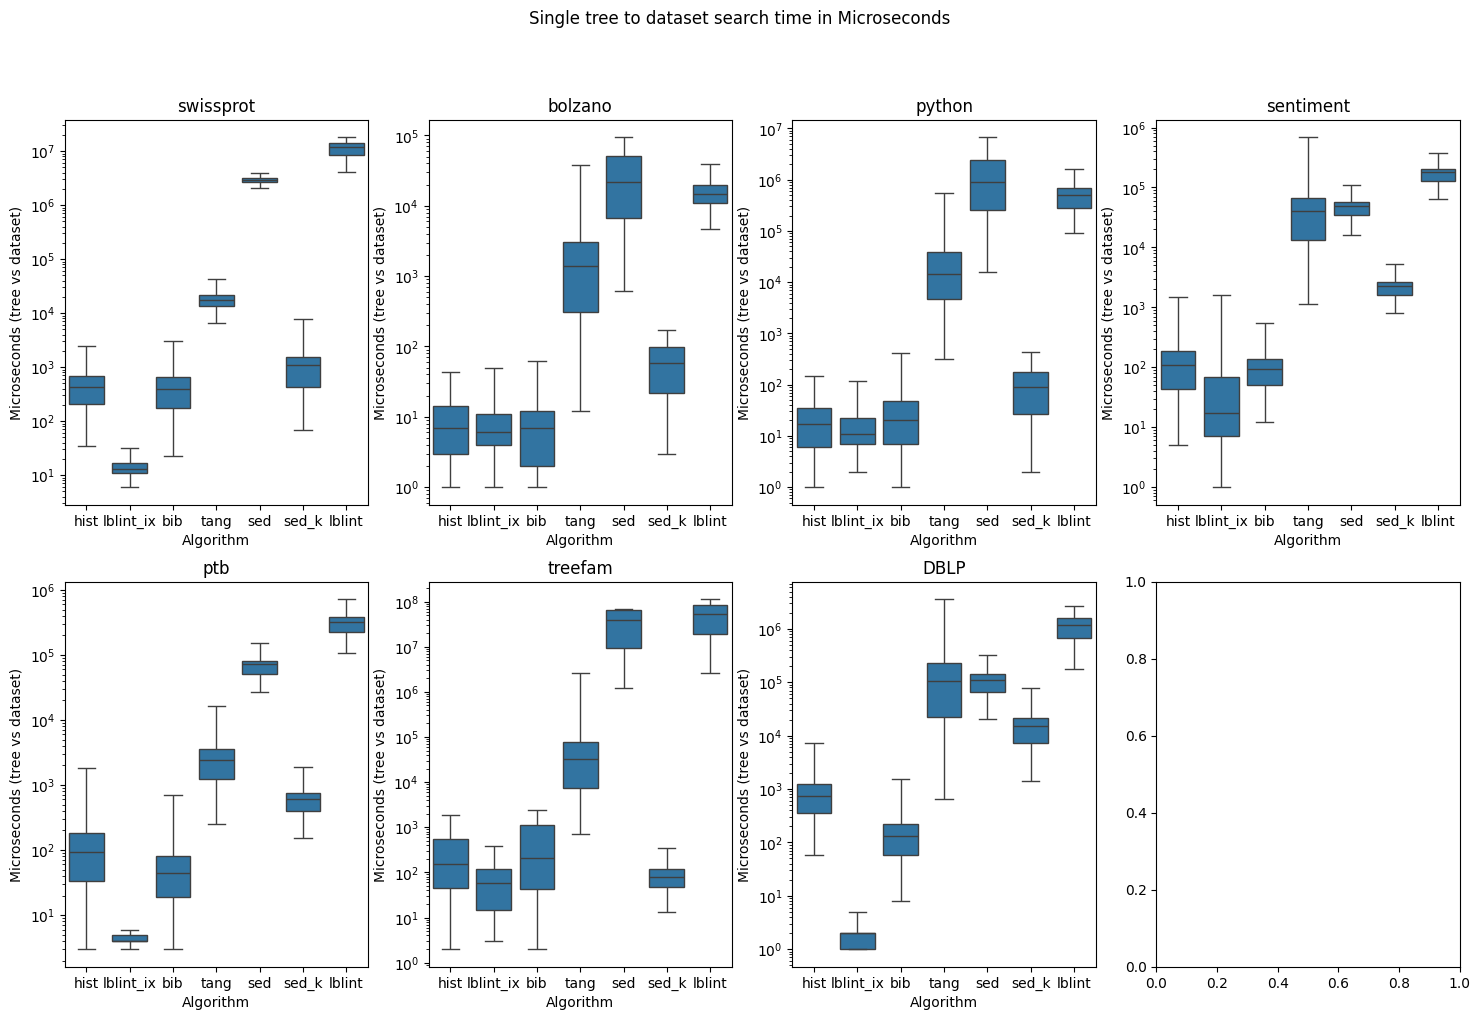

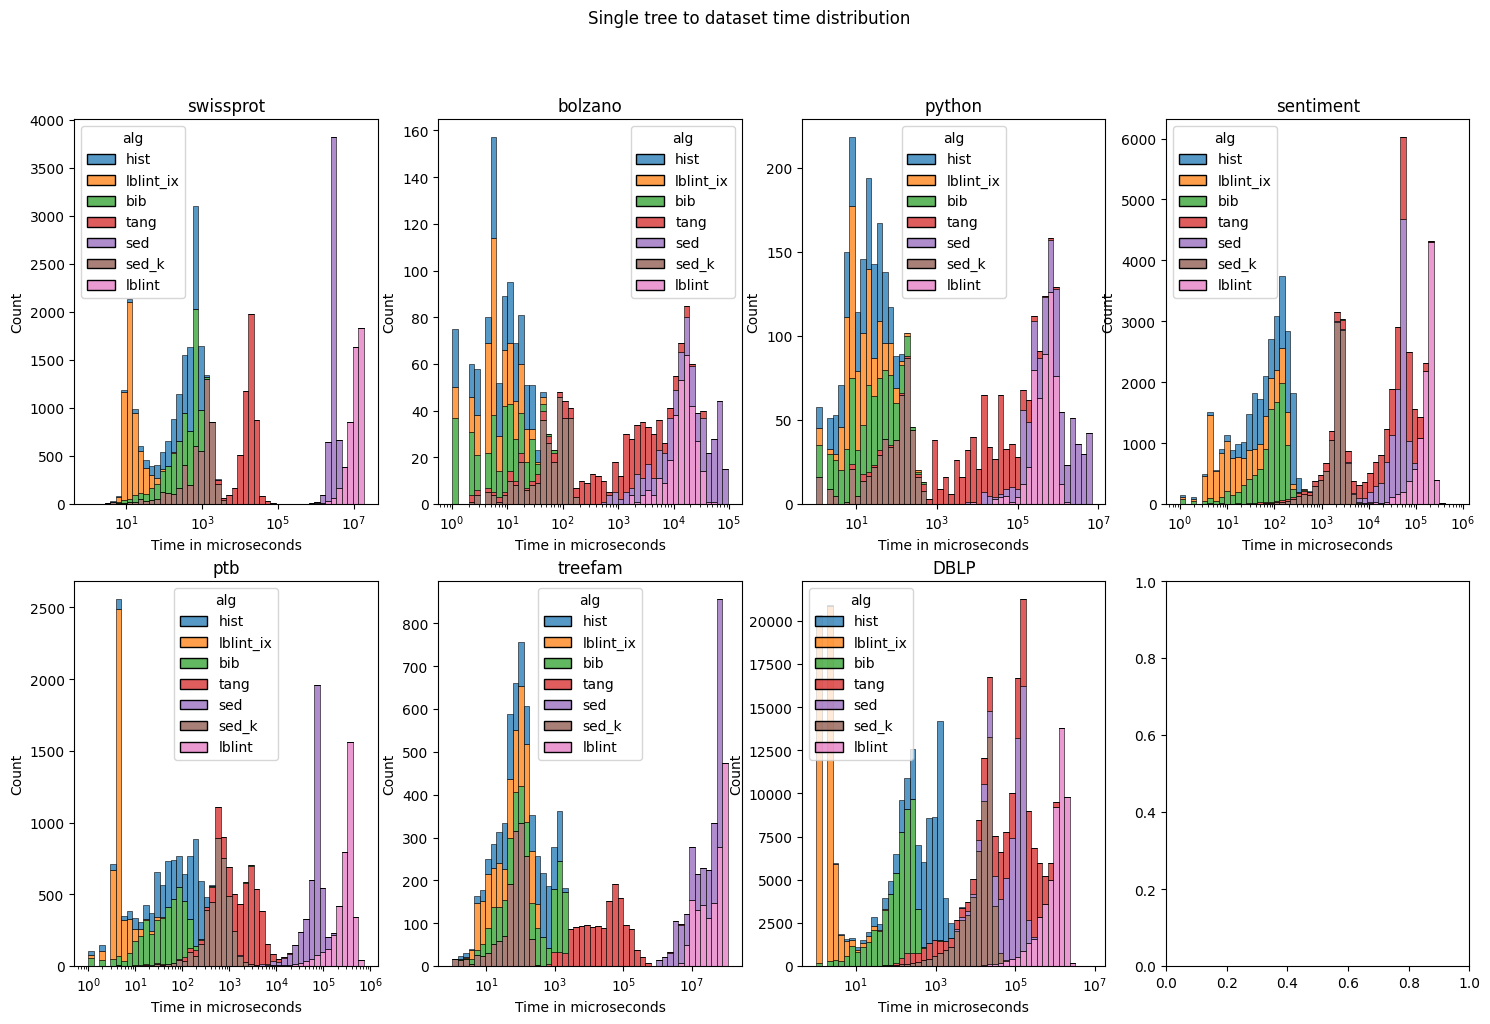

In [7]:
f, axes = plt.subplots(2, 4, figsize=(18, 11))
f.suptitle('Single tree to dataset search time in Microseconds')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)
    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = alg
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

Algorithm,bib,hist,lblint,lblint_ix,sed,sed_k,tang
Dataset,,,,,,,
DBLP,0.513,83.084,95.199,99.726,99.949,99.949,0.007
bolzano,15.936,30.518,51.403,57.524,68.537,68.537,32.604
ptb,0.786,16.396,54.223,63.682,85.787,85.787,0.459
python,9.882,27.136,64.567,73.036,87.743,87.743,15.723
sentiment,1.288,13.470,33.344,37.907,56.211,56.211,2.607
swissprot,3.419,51.613,84.210,84.210,94.118,94.118,0.004
treefam,53.061,86.908,99.363,100.000,100.000,100.000,5.710


[Text(0.5, 1.0, 'Precision heatmap')]

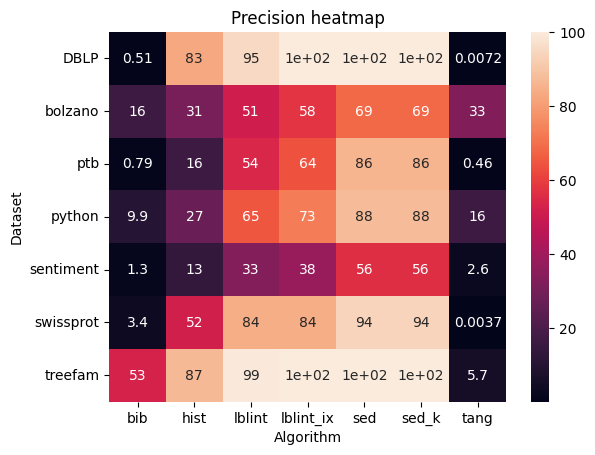

In [8]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = alg
        summary['Dataset'] = ds
        # tpt - time per tree - total time / (number of trees)
        summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df

pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Precision heatmap')

In [9]:
BASEPATH = 'results/histograms'
histogram_methods = ['all', 'degree', 'leaf', 'label']
def load_histo_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for hst in histogram_methods:
        path = f'{BASEPATH}/{dataset.lower()}/hist_{hst}_us.txt'
        if not exists(path):
            print(hst, 'is not computed for', dataset, f'{path} skipping')
            continue
        
        path2 = f'{BASEPATH}/{dataset.lower()}/precision-hist-{hst}-{threshold}.txt'
        df = pd.read_csv(path, names=["time"])
        precision = pd.read_csv(path2, delimiter=';')
        algorithm_times[hst] = [df, precision]
    return algorithm_times

In [12]:
dataframes = dict()
for ds, t in tested_values:
    dataframes[ds] = load_histo_dataset(ds, t)


all is not computed for bolzano results/histograms/bolzano/hist_all_us.txt skipping
degree is not computed for bolzano results/histograms/bolzano/hist_degree_us.txt skipping
leaf is not computed for bolzano results/histograms/bolzano/hist_leaf_us.txt skipping
label is not computed for bolzano results/histograms/bolzano/hist_label_us.txt skipping
all is not computed for python results/histograms/python/hist_all_us.txt skipping
degree is not computed for python results/histograms/python/hist_degree_us.txt skipping
leaf is not computed for python results/histograms/python/hist_leaf_us.txt skipping
label is not computed for python results/histograms/python/hist_label_us.txt skipping
degree is not computed for DBLP results/histograms/dblp/hist_degree_us.txt skipping
leaf is not computed for DBLP results/histograms/dblp/hist_leaf_us.txt skipping
label is not computed for DBLP results/histograms/dblp/hist_label_us.txt skipping


In [16]:
dataframes['swissprot']['all'][1]

,Correct trees,Incorrect trees,Precision,Total Time
0,16,3,0.842105,2703


Printing  swissprot
Printing  sentiment
Printing  ptb
Printing  treefam
Printing  DBLP


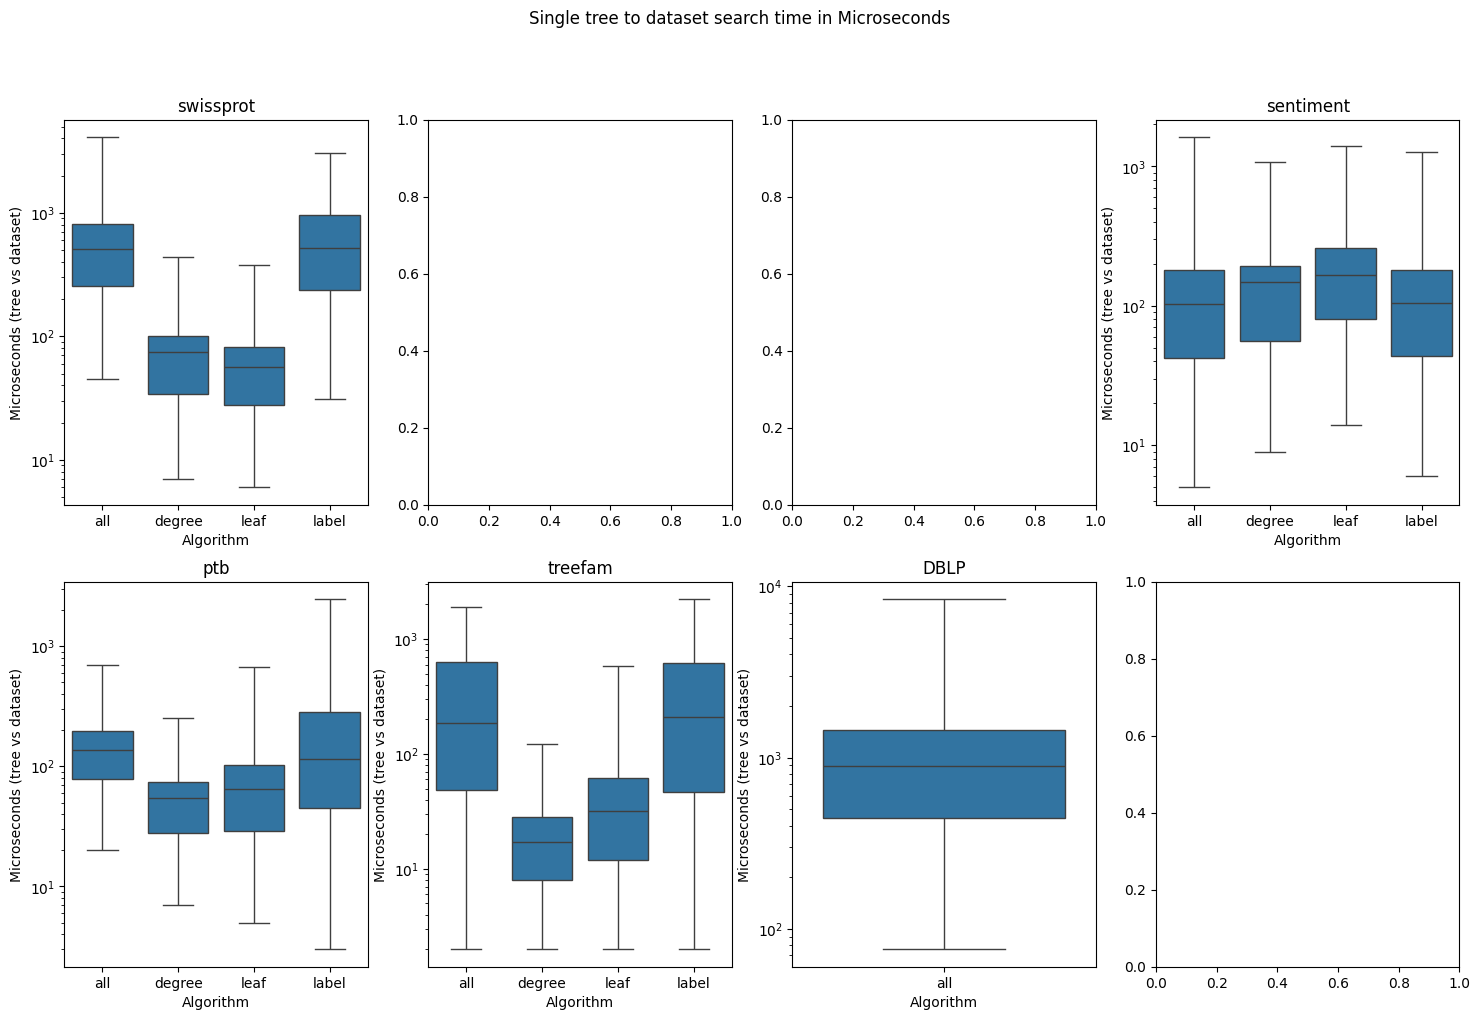

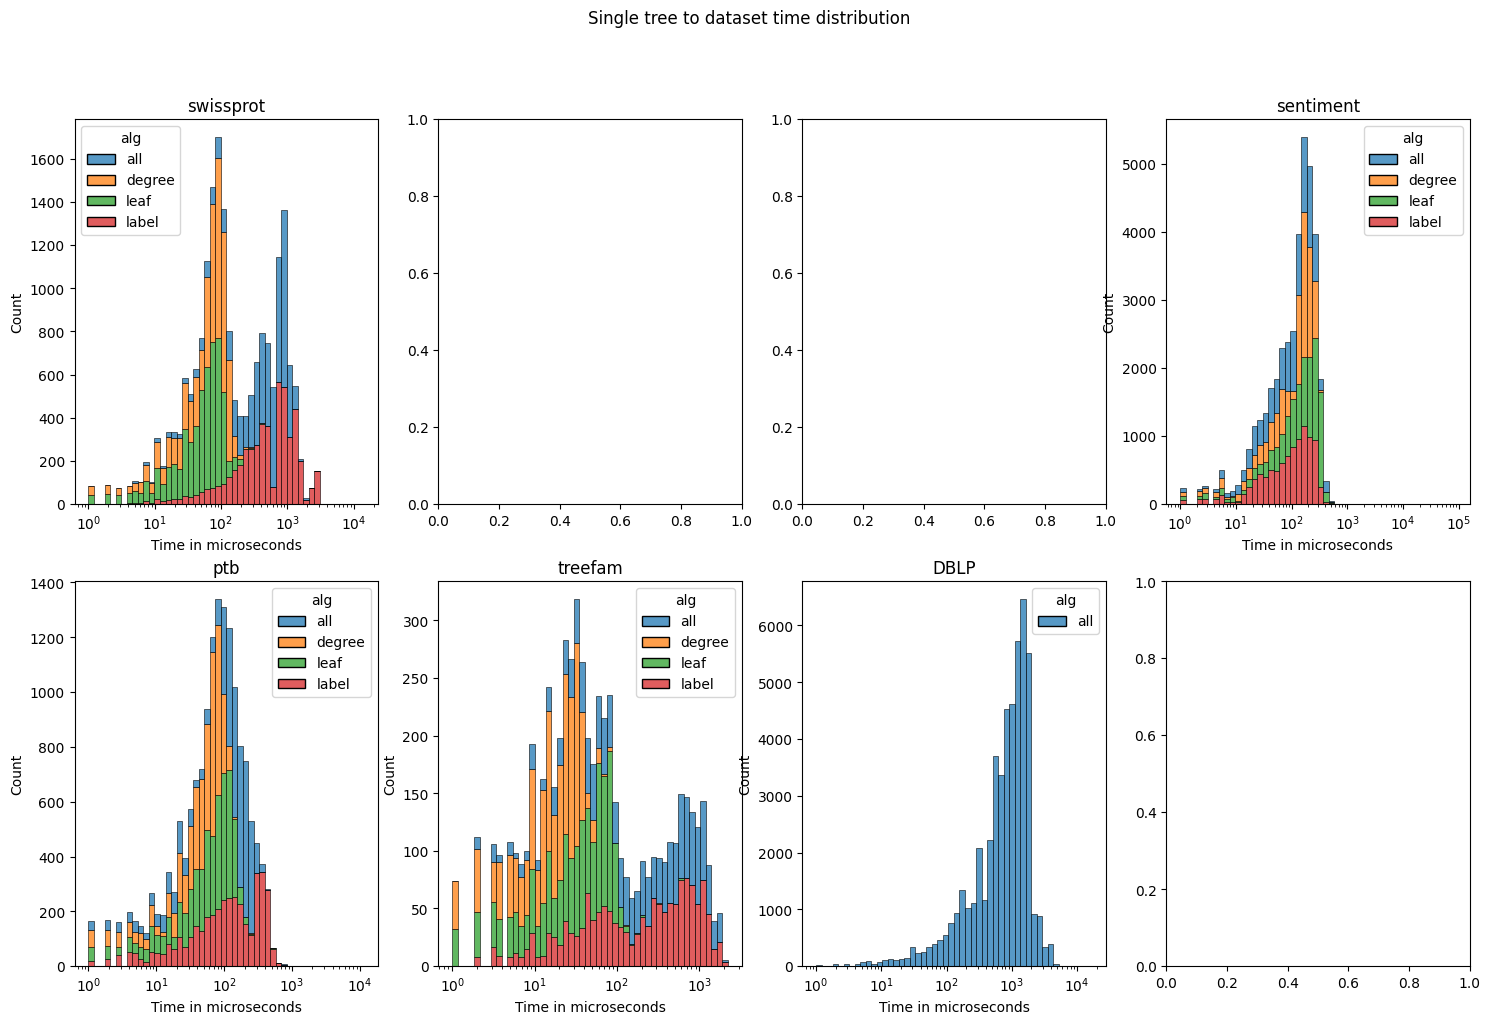

In [29]:
f, axes = plt.subplots(2, 4, figsize=(18, 11))
f.suptitle('Single tree to dataset search time in Microseconds')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    if ds in ['bolzano', 'python']:
        continue
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)
    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = alg
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

Algorithm,all,degree,label,leaf
Dataset,,,,
DBLP,0.475880,0.000000,0.000000,0.000000
ptb,0.337100,0.000410,0.337100,0.002029
sentiment,0.333442,0.004721,0.333436,0.015167
swissprot,0.842105,0.000006,0.842105,0.000020
treefam,0.990446,0.010968,0.990446,0.036757


[Text(0.5, 1.0, 'Precision heatmap')]

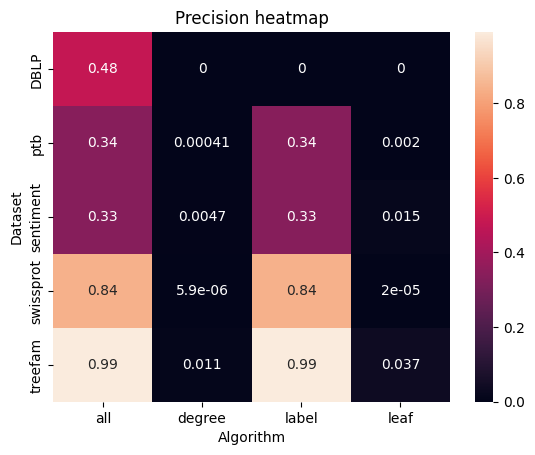

In [17]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = alg
        summary['Dataset'] = ds
        # tpt - time per tree - total time / (number of trees)
        summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df

pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Precision heatmap')